# Imports

In [1]:
from sklearn.manifold import TSNE, MDS
from keras.models import load_model
from IPython.display import SVG, Audio, display
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('../voicemap/')
sys.path.append('../')
from librispeech import LibriSpeechDataset
from utils import whiten, contrastive_loss
from config import LIBRISPEECH_SAMPLING_RATE

In [3]:
from keras.models import model_from_json

# Load and visualise pretrained model

In [4]:
model_path = '/home/bender/work/speech_rec/voicemap/models/siemese_final.hdf5'
downsampling = 4

In [5]:
!ls /home/bender/work/speech_rec/voicemap/models/siemese_final.hdf5

/home/bender/work/speech_rec/voicemap/models/siemese_final.hdf5


In [6]:
siamese = load_model(model_path)

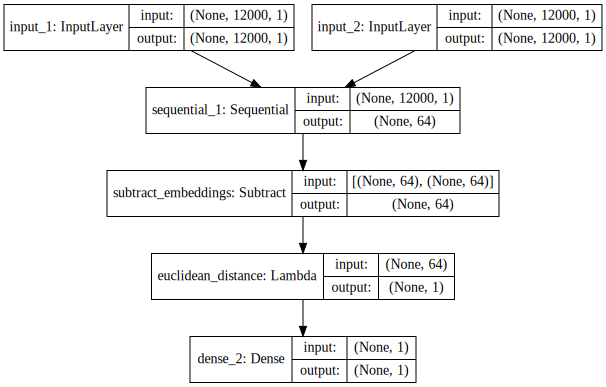

In [24]:
SVG(model_to_dot(siamese, show_shapes=True).create(prog='dot', format='svg'))

# Extract encoder
This extracts the encoder network that maps a single sample to a low dimensional space from the siamese network that takes two inputs.

In [7]:
from keras.models import Model
from keras.layers import Input

In [8]:
inputs = Input(shape=(12000,1))

encoded = siamese.layers[2](inputs)

In [9]:
encoder = Model(inputs=inputs, outputs=encoded)

In [10]:
encoder = siamese.layers[2]
encoder.compile(loss='mse',optimizer='adam')

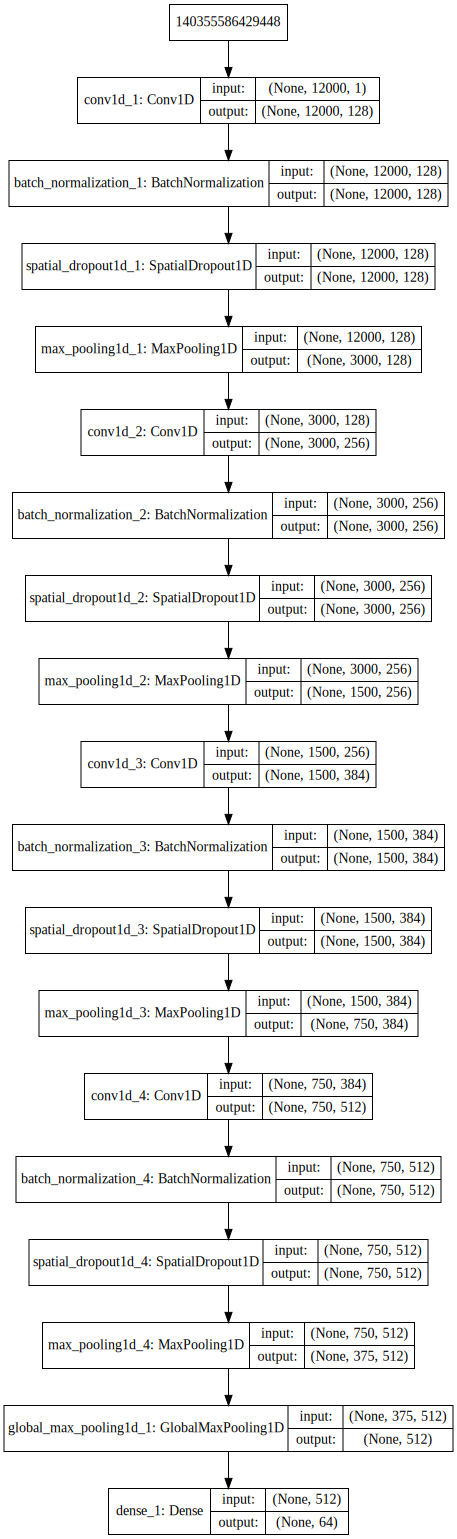

In [11]:
SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg'))

# Get data

In [12]:
def preprocessor(downsampling, whitening=True):
    def preprocessor_(batch):
        ([i_1, i_2], labels) = batch
        i_1 = i_1[:, ::downsampling, :]
        i_2 = i_2[:, ::downsampling, :]
        if whitening:
            i_1, i_2 = whiten(i_1), whiten(i_2)

        return [i_1, i_2], labels

    return preprocessor_


whiten_downsample = preprocessor(downsampling, whitening=True)

In [13]:
training_set = ['train-clean-100', 'train-clean-360']
train = LibriSpeechDataset(training_set, 3, stochastic=False)
validation_set = ['dev-clean']
valid = LibriSpeechDataset(validation_set, 3, stochastic=False)

Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['train-clean-100', 'train-clean-360']
Finished indexing data. 129652 usable files found.
Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['dev-clean']
Finished indexing data. 2303 usable files found.


### Random samples from subset of speakers

In [14]:
n_speakers = 20
m_samples = 10
n_random_speakers = valid.df['speaker_id'].sample(n_speakers).values

In [15]:
# Get m samples from each speaker
X, y, indexes = [], [], []
for i in n_random_speakers:
    ids = valid.df[valid.df['speaker_id']==i]['id'].sample(m_samples).values
    Z = [train[i] for i in ids]
    X_ = np.stack(list(zip(*Z))[0])[:, :, np.newaxis]
    y_ = np.stack(list(zip(*Z))[1])[:, np.newaxis]
    [X_, _], _ = whiten_downsample(([X_, X_], []))
    
    X.append(X_)
    y.append(y_[:, 0])
    indexes.append(ids)
    
X = np.concatenate(X)
y = np.concatenate(y)
indexes = np.concatenate(indexes)

# Embed

In [16]:
embeddings = encoder.predict(X)
embeddings.shape

(200, 64)

# Dimensionality Reduction

In [17]:
def compare_samples(a, b):
    sample_a = train[a]
    sample_b = train[b]

    print('Sample A ({}):'.format(a))
    display(Audio(data=sample_a[0],rate=LIBRISPEECH_SAMPLING_RATE))
    print('Sample B ({}):'.format(b))
    display(Audio(data=sample_b[0],rate=LIBRISPEECH_SAMPLING_RATE))

In [18]:
tsne = TSNE(perplexity=30,learning_rate=1000, early_exaggeration=1)

tsne_embeddings = tsne.fit_transform(embeddings)
tsne_embeddings.shape

(200, 2)

In [19]:
gender_markers = np.array([0 if train.df[train.df['id']==i]['sex'].values[0] == 'M' else 1 for i in indexes])

In [20]:
Z = np.hstack([tsne_embeddings, y[:, np.newaxis], gender_markers[:, np.newaxis]])
m = Z[Z[:, 3] == 0]
f = Z[Z[:, 3] == 1]
m.shape, f.shape

((47, 4), (153, 4))

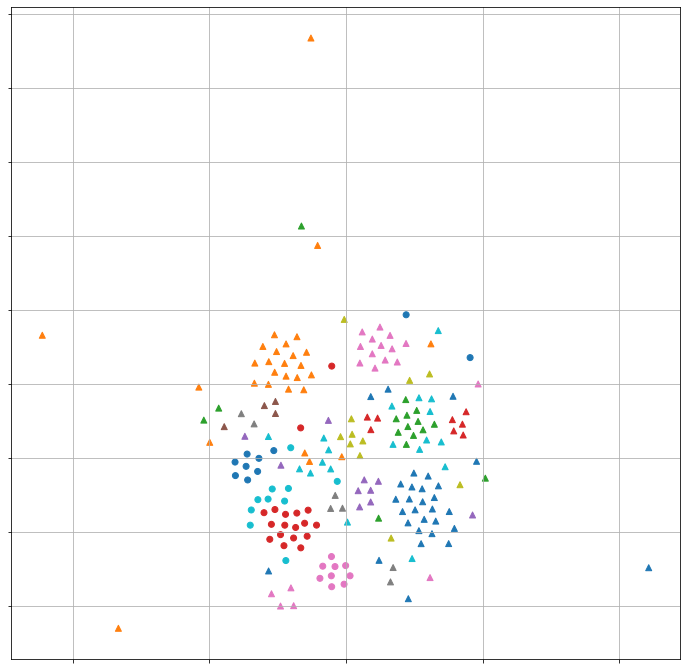

In [21]:
plt.figure(figsize=(12,12))

ax = plt.axes()
ax.scatter(m[:, 0], m[:, 1], c=[np.unique(m[:, 2]).tolist().index(i) for i in m[:, 2]], 
           marker='o', cmap='tab10')
ax.scatter(f[:, 0], f[:, 1], c=[np.unique(f[:, 2]).tolist().index(i) for i in f[:, 2]], 
           marker='^', cmap='tab10')

# Uncomment this block to show indexes of the samples in the dataset
# for x_, y_, idx, speaker_id in zip(two_d_embeddings[:, 0], two_d_embeddings[:, 1], indexes, y):
#     if np.random.random() < 0.025:
#         plt.text(x_, y_, idx)

ax.axes.set_xticklabels([])
ax.axes.set_yticklabels([])
plt.grid()
plt.show()

In [22]:
compare_samples(11637, 15334)

Sample A (11637):


Sample B (15334):
